In [2]:
import redis
import pandas

In [3]:
import mlrun

In [4]:
import mlrun.feature_store as fs
from mlrun.datastore.targets import RedisNoSqlTarget
from mlrun.datastore import HttpSource

In [5]:
project = mlrun.get_or_create_project(name='redis',user_project=True,context='./redis')

> 2022-09-18 13:06:10,826 [info] loaded project redis from MLRun DB


In [6]:
redis_path='redis://my-release-redis-master.default:6379'

In [7]:
source_path = './redis/test_fs.csv'
sample_path = './redis/sample_df_1.csv'

In [8]:
df = pandas.read_csv(sample_path)

In [9]:
df

,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestampsource_transaction,source,target,device,event,timestampsource_user_data
0,92,3,M,28007,28007,es_transportation,56.78,0,2022-07-27 18:54:23.114820214,C1150646122,M1823072687,f34c52c59d7c45b9a8a3241d0f408e96,login,2022-09-18 12:51:41.894264
1,76,3,F,28007,28007,es_transportation,17.11,0,2022-07-27 03:23:43.328150969,C609452246,M1823072687,e9deb3acc50f4372b6657a26b8695843,details_change,2022-09-18 12:51:43.894843
2,114,1,F,28007,28007,es_contents,65.88,0,2022-07-27 19:28:24.704280354,C2085186254,M1313686961,17958b9d97164661b7fb5e0f895be0b0,login,2022-09-18 12:51:45.896242
3,127,3,M,28007,28007,es_transportation,16.06,0,2022-07-26 10:56:57.024736975,C181787207,M1823072687,4dc7860c93024b4f9efd33d9bafe4395,login,2022-09-18 12:51:47.898788
4,76,3,F,28007,28007,es_transportation,17.11,0,2022-07-27 03:23:43.328150969,C609452246,M1823072687,e9deb3acc50f4372b6657a26b8695843,login,2022-09-18 12:51:49.901345
5,99,4,M,28007,28007,es_wellnessandbeauty,194.65,0,2022-07-27 20:26:06.020643428,C1165343027,M1535107174,6c0d2b01fb364e1ca9e43a9c219b59c0,details_change,2022-09-18 12:51:51.903871
6,127,3,M,28007,28007,es_transportation,16.06,0,2022-07-26 10:56:57.024736975,C181787207,M1823072687,4dc7860c93024b4f9efd33d9bafe4395,login,2022-09-18 12:51:53.906404
7,127,3,M,28007,28007,es_transportation,16.06,0,2022-07-26 10:56:57.024736975,C181787207,M1823072687,4dc7860c93024b4f9efd33d9bafe4395,login,2022-09-18 12:51:55.907778
8,76,3,F,28007,28007,es_transportation,17.11,0,2022-07-27 03:23:43.328150969,C609452246,M1823072687,e9deb3acc50f4372b6657a26b8695843,login,2022-09-18 12:51:57.910319
9,76,3,F,28007,28007,es_transportation,17.11,0,2022-07-27 03:23:43.328150969,C609452246,M1823072687,e9deb3acc50f4372b6657a26b8695843,login,2022-09-18 12:51:59.912902


In [10]:
# mlrun: start-code

In [11]:
def add_age_2(event):
    event['age_2']=event['age']+2
    return event

def len_event(event):
    event['len_event']=len(event['event'])
    return event

def check_len_event(event):
    if event['len_event'] > 5:
        event['check_len_event'] = 'Bigger Then 5'
        return event 
    else:
        event['check_len_event'] = 'Smaller Or Equal to 5'
        return event

In [12]:
# mlrun: end-code

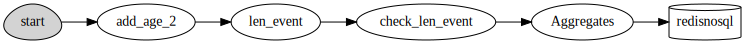

In [13]:
key = "source"
fset = fs.FeatureSet("purge_1", entities=[fs.Entity(key)], timestamp_key="timestampsource_user_data")

fset.graph.to(name='add_age_2',handler='add_age_2') \
            .to(name='len_event',handler='len_event').to(name='check_len_event',handler='check_len_event').respond()

fset.add_aggregation("amount", ["sum","max"], "1h", "10m", name="amount_agg")
fset.add_aggregation("len_event", ["sum","max"], "1h", "10m", name="len_event_agg")
targets = [RedisNoSqlTarget(path=redis_path)]
fset.set_targets(
    targets=targets,
    with_defaults=False,
)

fset.plot(rankdir='LR',with_targets=True)

In [14]:
ingest_df=fs.ingest(fset, df,overwrite=False)

In [15]:
ingest_df

,amount_agg_sum_1h,amount_agg_max_1h,len_event_agg_sum_1h,len_event_agg_max_1h,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestampsource_transaction,target,device,event,timestampsource_user_data,age_2,len_event,check_len_event
source,,,,,,,,,,,,,,,,,,,,
C1150646122,113.56,56.78,10.0,5.0,92,3,M,28007,28007,es_transportation,56.78,0,2022-07-27 18:54:23.114820214,M1823072687,f34c52c59d7c45b9a8a3241d0f408e96,login,2022-09-18 12:51:41.894264,5,5,Smaller Or Equal to 5
C609452246,85.55,17.11,43.0,14.0,76,3,F,28007,28007,es_transportation,17.11,0,2022-07-27 03:23:43.328150969,M1823072687,e9deb3acc50f4372b6657a26b8695843,details_change,2022-09-18 12:51:43.894843,5,14,Bigger Then 5
C2085186254,131.76,65.88,10.0,5.0,114,1,F,28007,28007,es_contents,65.88,0,2022-07-27 19:28:24.704280354,M1313686961,17958b9d97164661b7fb5e0f895be0b0,login,2022-09-18 12:51:45.896242,3,5,Smaller Or Equal to 5
C181787207,64.24,16.06,20.0,5.0,127,3,M,28007,28007,es_transportation,16.06,0,2022-07-26 10:56:57.024736975,M1823072687,4dc7860c93024b4f9efd33d9bafe4395,login,2022-09-18 12:51:47.898788,5,5,Smaller Or Equal to 5
C609452246,102.66,17.11,48.0,14.0,76,3,F,28007,28007,es_transportation,17.11,0,2022-07-27 03:23:43.328150969,M1823072687,e9deb3acc50f4372b6657a26b8695843,login,2022-09-18 12:51:49.901345,5,5,Smaller Or Equal to 5
C1165343027,389.30,194.65,28.0,14.0,99,4,M,28007,28007,es_wellnessandbeauty,194.65,0,2022-07-27 20:26:06.020643428,M1535107174,6c0d2b01fb364e1ca9e43a9c219b59c0,details_change,2022-09-18 12:51:51.903871,6,14,Bigger Then 5
C181787207,80.30,16.06,25.0,5.0,127,3,M,28007,28007,es_transportation,16.06,0,2022-07-26 10:56:57.024736975,M1823072687,4dc7860c93024b4f9efd33d9bafe4395,login,2022-09-18 12:51:53.906404,5,5,Smaller Or Equal to 5
C181787207,96.36,16.06,30.0,5.0,127,3,M,28007,28007,es_transportation,16.06,0,2022-07-26 10:56:57.024736975,M1823072687,4dc7860c93024b4f9efd33d9bafe4395,login,2022-09-18 12:51:55.907778,5,5,Smaller Or Equal to 5
C609452246,119.77,17.11,53.0,14.0,76,3,F,28007,28007,es_transportation,17.11,0,2022-07-27 03:23:43.328150969,M1823072687,e9deb3acc50f4372b6657a26b8695843,login,2022-09-18 12:51:57.910319,5,5,Smaller Or Equal to 5


In [21]:
sample_path = './redis/sample_df_2.csv'
df = pandas.read_csv(sample_path)
ingest_df=fs.ingest(fset, df,overwrite=False)

In [22]:
features = [
    "purge.*",
]

vector = fs.FeatureVector("purge-vector",features=features,description="this is my vector")
vector.save()

In [23]:
svc = fs.get_online_feature_service("purge-vector")
resp = svc.get([{"source": 'C181787207'}])

In [24]:
resp

[{'amount_agg_sum_1h': 48.17999999999999,
  'amount_agg_max_1h': 16.06,
  'len_event_agg_sum_1h': 15.0,
  'len_event_agg_max_1h': 5.0,
  'step': 127,
  'age': 3,
  'gender': 'M',
  'zipcodeOri': 28007,
  'zipMerchant': 28007,
  'category': 'es_transportation',
  'amount': 16.06,
  'fraud': 0,
  'timestampsource_transaction': '2022-07-26 10:56:57.024736975',
  'target': 'M1823072687',
  'device': '4dc7860c93024b4f9efd33d9bafe4395',
  'event': 'login',
  'age_2': 5,
  'len_event': 5,
  'check_len_event': 'Smaller Or Equal to 5'}]

In [32]:
func = mlrun.code_to_function('fs_ingest',kind='serving',image='mlrun/mlrun')

In [33]:
server_fs = fs.deploy_ingestion_service(featureset=fset,source=HttpSource(key_field='source',time_field="timestampsource_user_data"),run_config=fs.RunConfig(func,local=True))

In [34]:
import time
ingest_dict=df.to_dict(orient='records')[0]
ingest_dict['source']=f'111111111'
ingest_dict['age']=11
ingest_dict['step']=1
ingest_dict['amount']=1000

res=server_fs.test('/',ingest_dict)
print(res)

{'id': 'b4d236959b5f4dcd8b984381d94399ed'}


In [35]:
svc = fs.get_online_feature_service("purge-vector")
resp = svc.get([{"source": '111111111'}])
resp

[None]

In [136]:
func_ingest_fs = fs.deploy_ingestion_service(featureset=fset,source=HttpSource(key_field='source',time_field="timestampsource_user_data"),run_config=fs.RunConfig(func))

> 2022-09-18 11:06:28,268 [info] Starting remote function deploy
2022-09-18 11:06:28  (info) Deploying function
2022-09-18 11:06:28  (info) Building
2022-09-18 11:06:28  (info) Staging files and preparing base images
2022-09-18 11:06:28  (info) Building processor image
2022-09-18 11:07:18  (info) Build complete
2022-09-18 11:07:26  (info) Function deploy complete
> 2022-09-18 11:07:26,553 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-redis-jovyan-fs-ingest.mlrun.svc.cluster.local:8080'], 'external_invocation_urls': ['localhost:31987']}


In [138]:
func_ingest_fs

'http://localhost:31987'

In [139]:
import time
ingest_dict=df.to_dict(orient='records')[1]
ingest_dict['source']=f'222222'
ingest_dict['age']=22
ingest_dict['step']=2
ingest_dict['amount']=2000

res=func.invoke('/',ingest_dict)
print(res)

> 2022-09-18 11:07:47,213 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-redis-jovyan-fs-ingest.mlrun.svc.cluster.local:8080/'}
{'id': '363a498c-e6d2-457f-b922-2bc320adb8d1'}


In [142]:
svc = fs.get_online_feature_service("purge-vector")
resp = svc.get([{"source": '222222'}])
resp

[None]